In [1]:
from scipy.signal import chirp
import numpy as np
from matplotlib import pyplot as plt
import math
import os
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
os.chdir("/Users/liutianlin/Desktop/Academics/MINDS/neuromorphic")
import matplotlib.pyplot as plot

import numpy as np
from matplotlib import pyplot as plt
import h5py
import DYNAPSETools.dynapseSpikesFitter as fitter

folderName = "/Users/liutianlin/Desktop/Academics/MINDS/neuromorphic/caer/myoutputs/thesis_output_aedat/"


plt.close('all')

# fileList = ['classificationBias_slowClassificationRes_seqPulse','baselineBias_classificationRes_seqPulse']


fileList = ['classificationBias_3coreClassificationResSlow_seqPulse','classificationBias_transferRes3Cores_seqPulse']


    
    

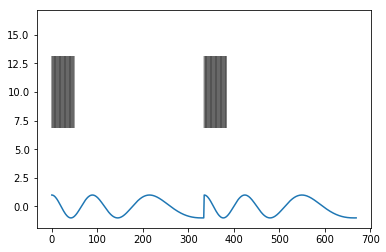

In [2]:
tEnd = 3.35
t = np.linspace(0, tEnd, 335)
w = chirp(t, f0= 1.25, f1= 0.25, t1= tEnd, method='linear') # the chirp signal
# w = chirp(t, f0= 6.25, f1= 0.25, t1= tEnd, method='linear') # the chirp signal

u = 2* np.concatenate((np.ones([1,50])[0], np.zeros((1,285))[0])) # the input pulse

repeatTime = 30
periodicChirpList = [w]
pulseSigList = [u]

for i in np.arange(repeatTime - 1):
    periodicChirpList.append(w)
    pulseSigList.append(u)

periodicChirp = np.array(periodicChirpList).flatten()    
pulseSig = np.array(pulseSigList).flatten()    

plot.eventplot(np.where(pulseSig[:2*335] == 2)[0], lineoffsets = 10, linelengths = 6.27, linewidths = 0.4, color = 'k')     


plt.plot(periodicChirp[:2*335])
# plt.plot(pulseSig[:2*335])
mse_train_dict = {}
mse_test_dict = {}

prediction_train_dict = {}
prediction_test_dict = {}

In [3]:
alphas ={}
alphas['classificationBias_3coreClassificationResSlow_seqPulse'] = 10
alphas['classificationBias_transferRes3Cores_seqPulse'] = 100


for this_File in fileList:

    print(this_File)

    trainDataset = this_File + '.hdf5'

    fileName = os.path.join(folderName, trainDataset)
    h5f = h5py.File(fileName, "r")
    importedData = h5f["data"][:]
    h5f.close()

    data = np.concatenate(importedData, axis = 1)


    data = data[:, :len(periodicChirp)] # match the size of input and target 

    nonzeroNeuronIndices = np.where(np.sum(data, axis = 1) > 1e-10)[0] 
    data = data[nonzeroNeuronIndices, :]

    trainTestSplit = int(2* len(periodicChirp)/4)

    trainData = data[:, :trainTestSplit]
    testData = data[:, trainTestSplit:]

    trainTarget = periodicChirp[:trainTestSplit]
    testTarget = periodicChirp[trainTestSplit:]

    # target = periodicChirp
    alpha  = alphas[this_File]
    regr = linear_model.Ridge(alpha = alpha) # carry out linear regression

    regr.fit(trainData.T, trainTarget.T)
    coefficients = regr.coef_

    prediction_train = fitter.sklearn_prevision(regr = regr, matrix = trainData)
    prediction_test = fitter.sklearn_prevision(regr = regr, matrix = testData)


    prediction_train_dict[this_File] = prediction_train
    prediction_test_dict[this_File] = prediction_test

    mse_train_dict[this_File] = round(mean_squared_error(prediction_train, trainTarget),2)

    mse_test_dict[this_File] = round(mean_squared_error(prediction_test, testTarget),2)



    print(mse_train_dict[this_File])

    print(mse_test_dict[this_File])

classificationBias_3coreClassificationResSlow_seqPulse
0.04
0.23
classificationBias_transferRes3Cores_seqPulse
0.04
0.38


In [28]:
prediction_test_dict

{'classificationBias_3coreClassificationResSlow_seqPulse': array([-0.93628395, -0.52683294, -0.5398451 , ..., -1.1165177 ,
        -1.1529547 , -0.7520101 ], dtype=float32),
 'classificationBias_transferRes3Cores_seqPulse': array([-0.8526978 , -0.8714785 , -0.6628756 , ..., -0.3673622 ,
        -0.53539056, -0.46551543], dtype=float32)}

In [29]:
mse_train_dict

{'classificationBias_3coreClassificationResSlow_seqPulse': 0.04,
 'classificationBias_transferRes3Cores_seqPulse': 0.04}

In [30]:
mse_test_dict

{'classificationBias_3coreClassificationResSlow_seqPulse': 0.23,
 'classificationBias_transferRes3Cores_seqPulse': 0.38}

# Visualize results

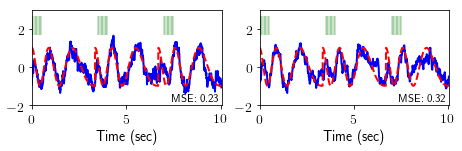

In [46]:
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)

# plt.rcParams.update({'font.size': 22})
width = 6.37
height = width / 1.618 / 2
fig = plt.figure()
# fig.subplots_adjust(left=.06, bottom=.16, right=.99, top=.97)
ax1 = fig.add_subplot(121)

nrPeriods = 3


ax1.plot(np.arange(nrPeriods * 335)/100, prediction_test_dict[fileList[0]][0:nrPeriods * 335], color = 'b',linewidth = 2)
ax1.plot(np.arange(nrPeriods * 335)/100, testTarget[:nrPeriods * 335], linestyle = '--', color = 'red', linewidth = 2)
# ax1.plot(np.arange(nrPeriods * 335)/100, pulseSig[:nrPeriods * 335], linestyle = '-', color = 'g', linewidth = 2)
# ax1.eventplot(np.where(pulseSig[:nrPeriods*335] == 2)[0]/100, lineoffsets = 2.2, linelengths = 1, linewidths = 0.4, color = 'k')     



inputSpikes = np.array([])

for i in np.arange(nrPeriods):
    inputSpikes = np.concatenate((inputSpikes, np.linspace(0, 0.5, 8) + i * 3.5 ))

ax1.eventplot(inputSpikes, lineoffsets = 2.2, linelengths = 1, linewidths = 0.4, color = 'g')     



ax1.set_ylim([-2, 3])
ax1.set_xlim([0, 10.05])
ax1.set_xlabel('Time (sec)')
ax1.text(7.4, -1.8, 'MSE: ' + str(mse_test_dict[fileList[0]]), fontsize=11)

# ax1.set_ylabel('Time (sec)')


ax2 = fig.add_subplot(122)
ax2.plot(np.arange(nrPeriods * 335)/100, prediction_test_dict[fileList[1]][:nrPeriods * 335], color = 'b', linewidth = 2)
ax2.plot(np.arange(nrPeriods * 335)/100, testTarget[:nrPeriods * 335], linestyle = '--', color = 'red',  linewidth = 2)
# ax2.plot(np.arange(nrPeriods * 335)/100, pulseSig[:nrPeriods * 335], linestyle = '-', color = 'g', linewidth = 2)
# ax2.eventplot(np.where(pulseSig[:nrPeriods*335] == 2)[0]/100, lineoffsets = 2.2, linelengths = 1, linewidths = 0.4, color = 'k')     
ax2.eventplot(inputSpikes, lineoffsets = 2.2, linelengths = 1, linewidths = 0.4, color = 'g')     

ax2.set_ylim([-2, 3])
ax2.set_xlim([0, 10.05])
ax2.text(7.4, -1.8, 'MSE: ' + str(mse_test_dict[fileList[1]]), fontsize=11)

ax2.set_xlabel('Time (sec)')


fig.set_size_inches(width, height)
# fig.subplots_adjust(left=.04, bottom=.05, right=.98, top=.97)

fig.subplots_adjust(left=.08, right=.99, top=.97, bottom = 0.3, wspace=0.2)


# plt.subplots_adjust(bottom = 0.3, wspace=0.1)
# plt.gcf().savefig('/Users/liutianlin/Desktop/Academics/MSc_thesis/my_msc_thesis/figs/thesis_regression.pdf', dpi=1200)
plt.show()


